<a href="https://colab.research.google.com/github/Baroka-wp/dive_ML/blob/master/TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Partie d'importation de bibliothèque


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from keras.datasets import mnist
import tensorflow as tf
tf.test.gpu_device_name() 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
from tensorflow.python.keras.layers import  Input, Embedding, Dot, Reshape, Dense
from tensorflow.python.keras.models import Model
from sklearn.preprocessing import OneHotEncoder


## [Problème 1] Retour sur zéro

- J'ai dû initialiser les poids
- Le calcul matriciel de la propagation vers l'avant était nécessaire
- Le calcul de la matrice de rétropropagation était nécessaire
- J'avais besoin d'une boucle d'époque
Calcul des pertes nécessaire

### Préparation du jeu de données


In [44]:
df_init = load_iris()
df = pd.DataFrame(df_init.data,columns=df_init.feature_names)
target_df = pd.DataFrame(df_init.target,columns=["species"])

df = pd.concat([df,target_df], axis=1)
df = df.loc[(df.species==1) | (df.species==2)]
X = X = df.loc[:, ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]]
y = df['species']

X = np.array(X)
y = np.array(y)

y[y == 1] = 0
y[y == 2] = 1

y = y.astype(np.int64)[:, np.newaxis]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

## [Problème 2] Considérez la correspondance entre scratch et TensorFlow


#### Création d'une classe pour le traitement par mini-batch


In [47]:
class SampleIterator():
    def __init__(self):
        self.X = [1,2,3,4,5]
        self.counter = 0
        self.stop = len(self.X)
    def __iter__(self):
        return self
    def __next__(self):
        if self.counter >= self.stop:
            raise StopIteration()
        x = self.X[self.counter]
        self.counter += 1
        return x
sample_iter = SampleIterator()
for x in sample_iter:
    print(x)

1
2
3
4
5


In [46]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

#### Paramètres d'hyperparamètres


In [54]:
learning_rate = 0.001
batch_size = 10
num_epochs = 100
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

#### Déterminer la forme des entrées et des sorties du réseau


In [55]:
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

In [56]:
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [58]:
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    tf.random.set_random_seed(0)
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int64)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
        total_loss /= n_samples
        val_loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}".format(epoch, total_loss, val_loss, acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 7.0241, val_loss : 67.6860, acc : 0.375
Epoch 1, loss : 3.4241, val_loss : 23.4026, acc : 0.312
Epoch 2, loss : 1.9387, val_loss : 11.6681, acc : 0.375
Epoch 3, loss : 2.0917, val_loss : 13.1400, acc : 0.312
Epoch 4, loss : 1.7685, val_loss : 17.7284, acc : 0.312
Epoch 5, loss : 1.6097, val_loss : 12.9607, acc : 0.312
Epoch 6, loss : 1.4402, val_loss : 10.0593, acc : 0.312
Epoch 7, loss : 1.3704, val_loss : 9.4797, acc : 0.312
Epoch 8, loss : 1.2536, val_loss : 9.8518, acc : 0.312
Epoch 9, loss : 1.1476, val_loss : 8.5670, acc : 0.375
Epoch 10, loss : 1.0930, val_loss : 8.0430, acc : 0.375
Epoch 11, loss : 1.0412, val_loss : 7.8791, acc : 0.375
Epoch 12, loss : 0.9804, val_loss : 7.1233, acc : 0.375
Epoch 13, loss : 0.9326, val_loss : 6.7908, acc : 0.375
Epoch 14, loss : 0.8792, val_loss : 6.2492, acc : 0.375
Epoch 15, loss : 0.8304, val_loss : 5.7681, acc : 0.375
Epoch 16, loss : 0.7835, val_loss : 5.2886, acc : 0.438
Epoch 17, loss : 0.7384, val_loss : 4.8037, acc : 0

D'après ce qui précède, nous voyons que l'initialisation des poids est effectuée par tf.Variable(tf.random_normal) ; Adam est utilisé comme optimiseur et la fonction d'activation passe par tf.nn.relu.

## [Problème 3] Créer un modèle d'Iris en utilisant les trois types de variables objectives


In [61]:
df_init = load_iris()
df = pd.DataFrame(df_init.data,columns=df_init.feature_names)
target_df = pd.DataFrame(df_init.target,columns=["species"])

df = pd.concat([df,target_df], axis=1)
X = X = df.loc[:, ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]]
y = df['species']

X = np.array(X)
y = np.array(y)

y = y.astype(np.int64)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

In [63]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=batch_size)

def example_net(x):
    
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] 
    return layer_output
                             
logits = example_net(X)

loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))

accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val_one_hot})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 0, loss : 9.7833, val_loss : 10.6563, acc : 0.667, val_acc : 0.778
Epoch 1, loss : 5.9695, val_loss : 3.0728, acc : 0.778, val_acc : 0.889
Epoch 2, loss : 2.1762, val_loss : 1.8169, acc : 0.778, val_acc : 0.875
Epoch 3, loss : 0.0070, val_loss : 0.6317, acc : 1.000, val_acc : 0.917
Epoch 4, loss : 0.0056, val_loss : 0.5414, acc : 1.000, val_acc : 0.931
Epoch 5, loss : 0.0002, val_loss : 0.5034, acc : 1.000, val_acc : 0.917
Epoch 6, loss : 0.0360, val_loss : 0.8326, acc : 1.000, val_acc : 0.903
Epoch 7, loss : 0.0045, val_loss : 0.9275, acc : 1.000, val_acc : 0.917
Epoch 8, loss : 0.0030, val_loss : 0.8121, acc : 1.000, val_acc : 0.903
Epoch 9, loss : 0.1338, val_loss : 1.0712, acc : 0.944, val_acc : 0.917
test_acc : 0.967


## [Problème 4] Créer un modèle de prix des logements


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

Epoch 0, loss : 4964973.5000, val_loss : 3729021.5000
Epoch 1, loss : 105874.4297, val_loss : 61050.7344
Epoch 2, loss : 48980.4844, val_loss : 49638.3750
Epoch 3, loss : 33488.4766, val_loss : 32951.8906
Epoch 4, loss : 27598.9863, val_loss : 25192.6465
Epoch 5, loss : 24195.6641, val_loss : 21238.5156
Epoch 6, loss : 21619.9473, val_loss : 18860.6230
Epoch 7, loss : 20570.0215, val_loss : 17997.9277
Epoch 8, loss : 18731.9805, val_loss : 15998.9805
Epoch 9, loss : 19999.5156, val_loss : 17339.9707
test_mse : 19999.516


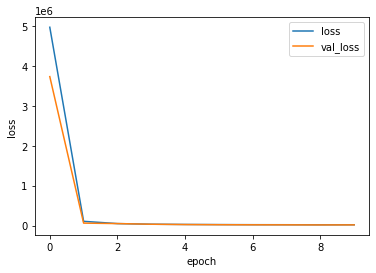

In [4]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

dataset_path ="/content/train.csv"
df = pd.read_csv(dataset_path)

y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)
y = y.astype(np.int)[:, np.newaxis]
y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] 
    return layer_output
                               
logits = example_net(X)
loss_op =  tf.losses.mean_squared_error(labels=Y, predictions=logits)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
y_pred = logits

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        loss = sess.run(loss_op, feed_dict={X: X_train, Y: y_train})
        loss_list.append(loss)
        val_loss = sess.run(loss_op, feed_dict={X: X_val, Y: y_val})
        val_loss_list.append(val_loss)    
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch, loss, val_loss))
    print("test_mse : {:.3f}".format(loss))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss_list, label='loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.legend()
    plt.show()

## [Problème 5] Créer un modèle de MNIST


In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

y_train = y_train.astype(np.int)[:, np.newaxis]
y_test = y_test.astype(np.int)[:, np.newaxis]

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:])
y_test_one_hot = enc.fit_transform(y_test[:])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):

    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] 
    return layer_output
                               
logits = example_net(X)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
max_Y = (tf.argmax(Y, 1))
max_Y_pred = tf.argmax(logits, 1)
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
    
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))

11501568/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias

Epoch 0, loss : 0.9809, val_loss : 1.2141, acc : 0.500, val_acc : 0.648
Epoch 1, loss : 0.9254, val_loss : 0.9614, acc : 0.600, val_acc : 0.776
Epoch 2, loss : 0.7081, val_loss : 0.7212, acc : 0.700, val_acc : 0.845
Epoch 3, loss : 0.6233, val_loss : 0.4046, acc : 0.700, val_acc : 0.903
Epoch 4, loss : 0.6234, val_loss : 0.4170, acc : 0.800, val_acc : 0.896
Epoch 5, loss : 0.6157, val_loss : 0.3721, acc : 0.800, val_acc : 0.916
Epoch 6, loss : 0.7452, val_loss : 0.3962, acc : 0.700, val_acc : 0.917
Epoch 7, loss : 0.6560, val_loss : 0.3623, acc : 0.800, val_acc : 0.924
Epoch 8, loss : 0.4046, val_loss : 0.3142, acc : 0.900, val_acc : 0.927
Epoch 9, loss : 0.2602, val_loss : 0.3467, acc : 0.900, val_acc : 0.932
test_acc : 0.934
